In [10]:
import numpy as np
import pandas as pd
import os, zipfile
from pathlib import Path

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model,layers
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import cv2

In [11]:
print("Are datasets unziped?: ", os.path.isdir("./surface-crack-detection/"))

if not os.path.isdir("./surface-crack-detection/"):
    zip = zipfile.ZipFile("./surface-crack-detection.zip")
    zip.extractall("./")
    zip.close()

Are datasets unziped?:  True


In [12]:
positive_dir = Path('./surface-crack-detection/Positive')
negative_dir = Path('./surface-crack-detection/Negative')

In [13]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

# ResNet50 (128 x 128)

In [14]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
df

,Filepath,Label
0,surface-crack-detection\Positive\03842.jpg,POSITIVE
1,surface-crack-detection\Positive\12899_1.jpg,POSITIVE
2,surface-crack-detection\Positive\15033_1.jpg,POSITIVE
3,surface-crack-detection\Negative\16782.jpg,NEGATIVE
4,surface-crack-detection\Positive\09202.jpg,POSITIVE
...,...,...
39995,surface-crack-detection\Positive\07814.jpg,POSITIVE
39996,surface-crack-detection\Negative\12512.jpg,NEGATIVE
39997,surface-crack-detection\Positive\05193.jpg,POSITIVE
39998,surface-crack-detection\Positive\12173_1.jpg,POSITIVE


In [15]:
train_df, test_df = train_test_split(df, train_size=0.9, shuffle=True, random_state=777)

In [16]:
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

In [17]:
img_size = (128, 128)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=777,
    subset='training')

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=777,
    subset='validation')

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=777)

Found 28800 validated image filenames belonging to 2 classes.
Found 7200 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


In [18]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [19]:
for layer in resnet.layers:
    layer.trainable=False

In [20]:
x = Flatten()(resnet.output)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
prediction = Dense(2, activation='sigmoid')(x)
model = Model(inputs=resnet.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_data,
                    validation_data=val_data,
                    batch_size=100,
                    epochs=50,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                patience=3,
                                restore_best_weights=True)
                            ]
                    )

Epoch 1/50
900/900 [==============================] - 42s 41ms/step - loss: 0.1155 - accuracy: 0.9599 - val_loss: 0.0980 - val_accuracy: 0.9667
Epoch 2/50
900/900 [==============================] - 37s 41ms/step - loss: 0.0667 - accuracy: 0.9790 - val_loss: 0.0500 - val_accuracy: 0.9828
Epoch 3/50
900/900 [==============================] - 37s 41ms/step - loss: 0.0605 - accuracy: 0.9818 - val_loss: 0.0582 - val_accuracy: 0.9801
Epoch 4/50
900/900 [==============================] - 37s 41ms/step - loss: 0.0604 - accuracy: 0.9814 - val_loss: 0.0526 - val_accuracy: 0.9812
Epoch 5/50
900/900 [==============================] - 37s 41ms/step - loss: 0.0547 - accuracy: 0.9825 - val_loss: 0.0409 - val_accuracy: 0.9849
Epoch 6/50
900/900 [==============================] - 37s 42ms/step - loss: 0.0495 - accuracy: 0.9851 - val_loss: 0.0404 - val_accuracy: 0.9864
Epoch 7/50
900/900 [==============================] - 38s 43ms/step - loss: 0.0464 - accuracy: 0.9852 - val_loss: 0.0389 - val_accuracy:

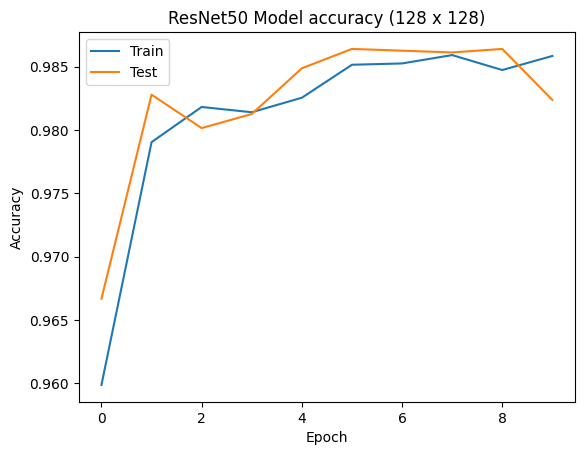

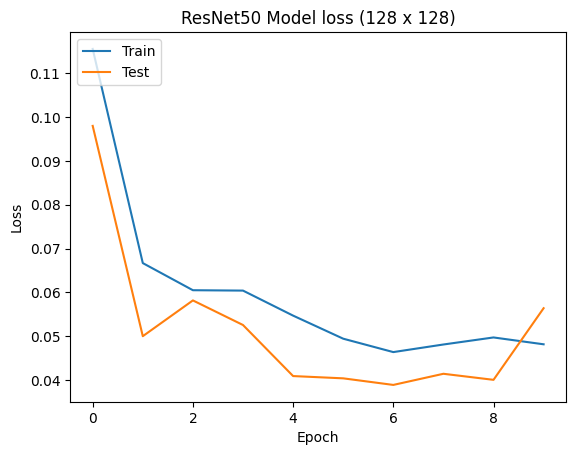

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model accuracy (128 x 128)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model loss (128 x 128)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))

In [24]:
evaluate_model(model, test_data)

    Test Loss: 0.03364
Test Accuracy: 98.72%


In [25]:
y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
y_pred = np.argmax(y_pred, axis=1)
clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])

print("ResNet50(128*128) Classification Report:\n----------------------\n", clr)

ResNet50(128*128) Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.99      0.98      0.99      1998
    POSITIVE       0.98      0.99      0.99      2002

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



C:\Users\mmqq2\AppData\Local\Temp\ipykernel_3256\1411156233.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))


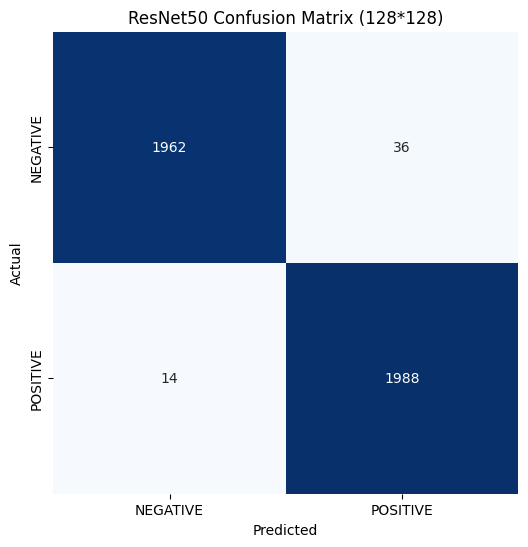

In [26]:
cm = confusion_matrix(test_data.labels, y_pred)
    
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("ResNet50 Confusion Matrix (128*128)")
plt.show()

# ResNet50 + VGG16 (128 x 128)

In [27]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

In [28]:
df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
df

,Filepath,Label
0,surface-crack-detection\Positive\03842.jpg,POSITIVE
1,surface-crack-detection\Positive\12899_1.jpg,POSITIVE
2,surface-crack-detection\Positive\15033_1.jpg,POSITIVE
3,surface-crack-detection\Negative\16782.jpg,NEGATIVE
4,surface-crack-detection\Positive\09202.jpg,POSITIVE
...,...,...
39995,surface-crack-detection\Positive\07814.jpg,POSITIVE
39996,surface-crack-detection\Negative\12512.jpg,NEGATIVE
39997,surface-crack-detection\Positive\05193.jpg,POSITIVE
39998,surface-crack-detection\Positive\12173_1.jpg,POSITIVE


In [29]:
train_df, test_df = train_test_split(df, train_size=0.9, shuffle=True, random_state=777)

In [30]:
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

In [31]:
img_size = (128, 128)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=777,
    subset='training')

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=777,
    subset='validation')

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=777)

Found 28800 validated image filenames belonging to 2 classes.
Found 7200 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


In [32]:
inputs = keras.Input(shape=(128, 128, 3), name="input")
resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
for layer in resnet.layers:
    layer.trainable = False
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input[0][0]']                  
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [33]:
vgg = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
for layer in vgg.layers:
    layer.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [34]:
merged_output = keras.layers.Concatenate()([resnet.output, vgg.output])
merged_output = keras.layers.GlobalAveragePooling2D()(merged_output)
x = Flatten()(merged_output)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
prediction = Dense(2, activation='sigmoid')(x)
model = Model(inputs=resnet.input, outputs=prediction)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input[0][0]']                  
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [35]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_data,
                    validation_data=val_data,
                    batch_size=100,
                    epochs=50,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                patience=3,
                                restore_best_weights=True)
                            ]
                    )

Epoch 1/50
900/900 [==============================] - 68s 71ms/step - loss: 0.0287 - accuracy: 0.9903 - val_loss: 0.0186 - val_accuracy: 0.9946
Epoch 2/50
900/900 [==============================] - 62s 69ms/step - loss: 0.0125 - accuracy: 0.9961 - val_loss: 0.0236 - val_accuracy: 0.9924
Epoch 3/50
900/900 [==============================] - 60s 67ms/step - loss: 0.0115 - accuracy: 0.9965 - val_loss: 0.0103 - val_accuracy: 0.9972
Epoch 4/50
900/900 [==============================] - 63s 70ms/step - loss: 0.0094 - accuracy: 0.9972 - val_loss: 0.0075 - val_accuracy: 0.9968
Epoch 5/50
900/900 [==============================] - 61s 67ms/step - loss: 0.0101 - accuracy: 0.9966 - val_loss: 0.0085 - val_accuracy: 0.9974
Epoch 6/50
900/900 [==============================] - 62s 68ms/step - loss: 0.0088 - accuracy: 0.9973 - val_loss: 0.0086 - val_accuracy: 0.9974
Epoch 7/50
900/900 [==============================] - 63s 70ms/step - loss: 0.0084 - accuracy: 0.9975 - val_loss: 0.0085 - val_accuracy:

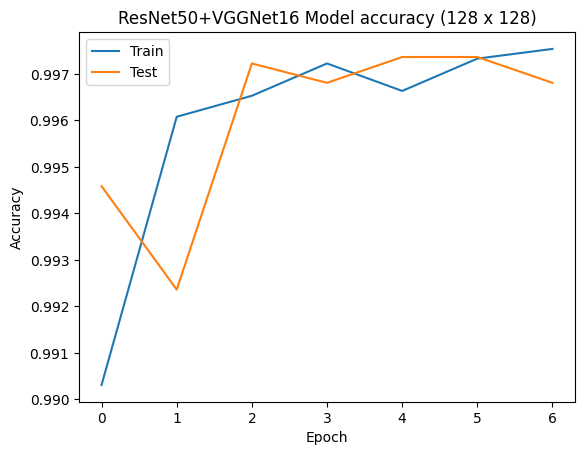

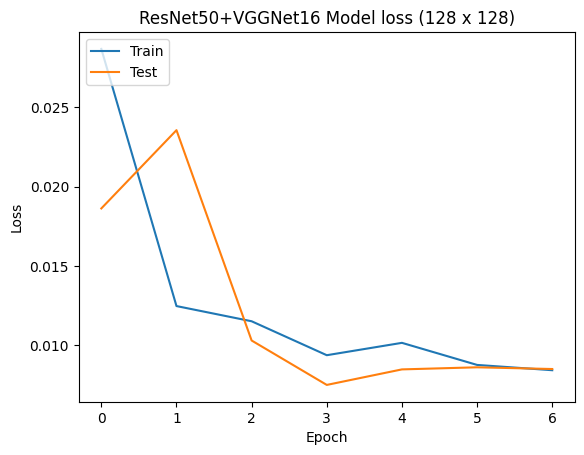

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50+VGGNet16 Model accuracy (128 x 128)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50+VGGNet16 Model loss (128 x 128)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [37]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
evaluate_model(model, test_data)

    Test Loss: 0.00535
Test Accuracy: 99.80%


In [38]:
y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
y_pred = np.argmax(y_pred, axis=1)
clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])

print("ResNet50+VGGNet16(128*128) Classification Report:\n----------------------\n", clr)

ResNet50+VGGNet16(128*128) Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00      1998
    POSITIVE       1.00      1.00      1.00      2002

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



C:\Users\mmqq2\AppData\Local\Temp\ipykernel_3256\2255572131.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))


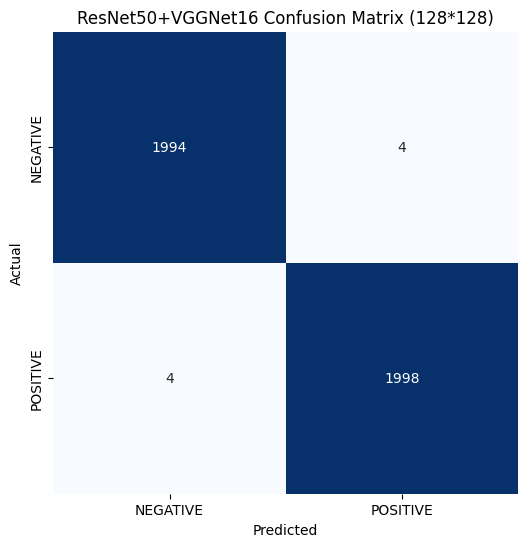

In [39]:
cm = confusion_matrix(test_data.labels, y_pred)
    
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("ResNet50+VGGNet16 Confusion Matrix (128*128)")
plt.show()